# Policy Gradients (Reinforce)

The REINFORCE algorithm is one implementation of the Policy Gradient family of algorithms, the idea of the algorithm is to have the policy represented by a neural network with $\theta$ parameters. The main idea of the algorithm is to change the network parameters to make the actions that provided positive rewards to be more probable to happen. The training phase optimize the following loss function:
$$\mathcal{L}=-\hat{Q}(s,a).log\pi_{\theta}(a|s)$$
Where:
* $\hat{Q}(s,a)$: It's an estimate of the state action function, that will modulate the probability of good actions to happen more often. This is also called **Advantage**.
* $\pi_{\theta}(a|s)$: It's the neural network that represent the policy and returns an distribution of actions given an state.

The steps of the algorithm
1. Initialize Network at random
2. Play N episodes saving their transitions "k" (s,a,r,s')
3. For every episode calculate $\hat{Q}(s,a)=\sum_{i=0} \gamma^i r_i$
4. Perform SGD to minimize the loss: $\mathcal{L}=-\hat{Q}(s,a).log\pi_{\theta}(a|s)$
5. Repeat 2 until convergence 

#### Disadvantages of Policy Gradients
* Full episodes are required, we need to wait a full episode to complete
* High Gradients Variance: This issue can be handled by subtracting a baseline from the Value estimation
* Exploration: The agent can converge to a local-optimal area and won't explore efficiently anymore. This can be solved by the Entropy Bonus technique that basically subtract the entropy of the policy from the loss function.
* Correlation between samples: This can be remedy by using parallel environments with same policy and using the experiences from different environments to train the policy.
* Less sample efficient: To deal with this we need another algorithm (Actor-Critic)

The image bellow can highlight the full episodic issue, where we have 2 trajectories where one or more actions could be bad, but as the final total score is good those bad actions will be averaged. That's one of the reasons why Policy Gradient methods are less sample efficient.

![alt text](imgs/episode_problem.png "Game")

Consider that the Advantage will "label" each experience on the epsisode trajectory, saying if the action was good or bad.




### Install
```bash
pip install gym
pip install box2d
pip install ffmpeg
pip install imageio-ffmpeg
pip install pygame
```

### References
* [Reference Implementation](https://towardsdatascience.com/breaking-down-richard-suttons-policy-gradient-9768602cb63b)
* [Tensorflow 2 Implementation](https://www.youtube.com/watch?v=mA9rxgOQyE4) and [TF Keras Implementation](https://www.youtube.com/watch?v=IS0V8z8HXrM)
* [Medium Article](https://towardsdatascience.com/policy-gradient-methods-104c783251e0) and [Source Code](https://github.com/jorditorresBCN/Deep-Reinforcement-Learning-Explained/blob/master/DRL_19_REINFORCE_Algorithm.ipynb)
* [Lunar Lander - Deep Reinforcement Learning, Noise Robustness, and Quantization](https://xusophia.github.io/DataSciFinalProj/)
* [Policy Gradient Demystified](https://amoudgl.github.io/blog/blog/policy-gradient/)
* [Policy Gradient CartPole](https://github.com/jorditorresBCN/Deep-Reinforcement-Learning-Explained/blob/master/DRL_19_REINFORCE_Algorithm.ipynb) and [Article](https://towardsdatascience.com/policy-gradient-methods-104c783251e0)
* [PPO From Scratch](https://medium.com/analytics-vidhya/coding-ppo-from-scratch-with-pytorch-part-1-4-613dfc1b14c8)
* [RL Book Sample](https://github.com/PacktPublishing/Hands-on-Reinforcement-Learning-with-PyTorch/blob/master/Section%204/4.3%20Policy%20Gradients%20REINFORCE%20Baseline.ipynb)
* [Karpathy lecture on OpenAI Summercamp](https://www.youtube.com/watch?v=tqrcjHuNdmQ)
* [Deep Reinforcement Learning: Pong from Pixels](http://karpathy.github.io/2016/05/31/rl/)
* [Reinforce with Cartpole environment](https://medium.com/@ts1829/policy-gradient-reinforcement-learning-in-pytorch-df1383ea0baf)
* [On Policy vs Off Policy](https://leimao.github.io/blog/RL-On-Policy-VS-Off-Policy/)
* [An Intuitive Explanation of Policy Gradient](https://towardsdatascience.com/an-intuitive-explanation-of-policy-gradient-part-1-reinforce-aa4392cbfd3c)
* https://medium.freecodecamp.org/an-introduction-to-policy-gradients-with-cartpole-and-doom-495b5ef2207f
* https://gist.github.com/tamlyn/a9d2b3990f9dab0f82d1dfc1588c876a
* http://inoryy.com/post/tensorflow2-deep-reinforcement-learning/
* [UCL RL Course](https://www.youtube.com/watch?v=iOh7QUZGyiU&list=PLqYmG7hTraZDNJre23vqCGIVpfZ_K2RZs)
* [Policy Gradient Algorithms](https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html)
* https://medium.com/@gabogarza/deep-reinforcement-learning-policy-gradients-8f6df70404e6
* https://towardsdatascience.com/learning-to-drive-smoothly-in-minutes-450a7cdb35f4
* http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture14.pdf

In [1]:
import numpy as np
import torch
import gym
from matplotlib import pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

num_episodes = 100000
t_max=5000
# Training hyperparameters

hidden_size = 64
learning_rate = 0.0001
gamma = 0.999

def save_best_model(model, file='pg_best.pth.tar'):
    # save the model
    torch.save(model, file)

### Create environment

In [2]:
env = gym.make("LunarLander-v2")
n_states = env.observation_space.shape[0]
n_actions = env.action_space.n
win_threshold = env.spec.reward_threshold
print('Number of states:', n_states)
print('Number of actions:', n_actions)
print('Amount of rewards consider as win:', env.spec.reward_threshold)

Number of states: 8
Number of actions: 4
Amount of rewards consider as win: 200


/Users/leonardoaraujo/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/leonardoaraujo/anaconda3/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


### Policy Approximation
This network will learn a policy, the input will be a state, and the output the logits that will represent the actions. 
$$\Pi(a|s)_\theta$$

In [3]:
class Net(nn.Module):
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(obs_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, n_actions)
        self.softmax_activation = torch.nn.Softmax(dim=0)
        self.action_space = [action for action in range(n_actions)]
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        action_probabilities = self.softmax_activation(x)
        action_idx = self.get_action(action_probabilities)
        log_prob_action = torch.log(action_probabilities.squeeze(0))[action_idx]
        return action_idx, log_prob_action
    
    def get_action(self, action_probs):
        # Choose a random action(integer) modulated by the policy action probabilities
        #return np.random.choice(self.action_space, p=action_probs.squeeze(0).detach().cpu().numpy())
        action_distribution = Categorical(action_probs)
        return action_distribution.sample().item()

### Instantiate Neural Network/Optimiser

In [4]:
#neural network (Function approximation)
policy_net = Net(n_states, hidden_size, n_actions)
#optimisation function
optimizer = optim.Adam(params=policy_net.parameters(), lr=learning_rate)

### Start Training
After several thousand episodes, something cool start to happen.

In [5]:
best_mean_reward = 0
list_sum_rewards_episode = []

for episode in range(num_episodes):
    # Reset environment
    curr_state = env.reset()
    prev_state = curr_state
    done = False
    trajectory = [] 
    list_log_action_prob = []
    total_reward = 0
    rewards_on_episode = []
    discounted_rewards = []
    
    # Play an episode to the END
    for t in range(t_max):
        action, log_action_prob = policy_net(torch.from_numpy(curr_state).float())
        curr_state, reward, done, info = env.step(action) 
        total_reward += reward
        rewards_on_episode.append(reward)
        list_log_action_prob.append(log_action_prob)
        # Save the trajectory on episode.
        trajectory.append((curr_state, action, reward, prev_state)) 
        prev_state = curr_state
        if done: 
            break
            
    # Select the rewards
    reward_batch = torch.Tensor([r for (s,a,r,s_prev) in trajectory])
    
    # Calculate the discounted rewards
    discounted_rewards = np.zeros_like(reward_batch)
    for t in range(len(reward_batch)):
        G_sum = 0
        discount = 1
        for k in range(t, len(reward_batch)):
            G_sum += reward_batch[k] * discount
            discount *= gamma
        discounted_rewards[t] = G_sum
    discounted_rewards = torch.Tensor(discounted_rewards)

    
    # Calculate Advantage
    advantage = (discounted_rewards - torch.mean(discounted_rewards)) / (torch.std(discounted_rewards))
    
    # Convert list of log probabilties of actions into a pytorch tensor
    log_prob_actions = torch.stack(list_log_action_prob)
    
    # Calculate Loss 
    # (observe that the advantage will modulate each action probability with it's discounted rewards)
    loss = (-log_prob_actions*advantage).sum()
    
    # Update policy weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    list_sum_rewards_episode.append(total_reward)
    
    mean_reward = np.mean(rewards_on_episode)
    if (episode % 500) == 0:
        print('episode {}\treward_mean: {:.2f} \tloss:{:.2f} \ttotal_reward:{}'.format(
            episode, mean_reward, loss.item(), total_reward))
    
    if mean_reward > best_mean_reward:
        print('Save best reward mean:', mean_reward)
        save_best_model(policy_net)
        best_mean_reward = mean_reward
    
    # If the mean reward is bigger than the completion score threshold we stop
    if mean_reward > win_threshold:
        print("Environment has been successfullly completed!")

episode 0	reward_mean: -1.14 	loss:0.53 	total_reward:-77.20529055939085
Save best reward mean: 0.040139707006367376
Save best reward mean: 0.3316600251334706
Save best reward mean: 0.534146797281234
episode 500	reward_mean: -0.88 	loss:-1.20 	total_reward:-59.67683586500082
episode 1000	reward_mean: -2.67 	loss:-1.40 	total_reward:-299.0232360720189
episode 1500	reward_mean: -0.73 	loss:1.98 	total_reward:-80.00508452940687
episode 2000	reward_mean: -0.15 	loss:-2.87 	total_reward:-20.290480749444143
episode 2500	reward_mean: -0.98 	loss:0.16 	total_reward:-82.25308165612446
episode 3000	reward_mean: 0.04 	loss:1.53 	total_reward:3.758901449964199
episode 3500	reward_mean: -1.04 	loss:-4.98 	total_reward:-77.02299161083172
episode 4000	reward_mean: -0.25 	loss:-0.27 	total_reward:-46.13469049646839
episode 4500	reward_mean: -0.89 	loss:-1.98 	total_reward:-69.98414367402023
episode 5000	reward_mean: -0.93 	loss:-0.87 	total_reward:-73.53510551567436
episode 5500	reward_mean: -0.58 	lo

KeyboardInterrupt: 

### Display some Stats

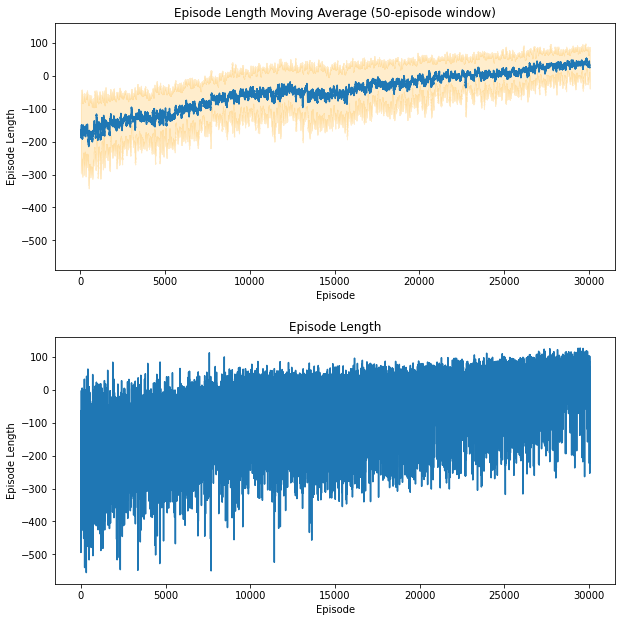

In [6]:
# number of episodes for rolling average
window = 50

# Create grid 2x1 plots
fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9, 9])

# Calculate the mean of the rewards over time
rolling_mean = pd.Series(list_sum_rewards_episode).rolling(window).mean()
# Calculate the standard deviation over time
std = pd.Series(list_sum_rewards_episode).rolling(window).std()

# Plot graph 1
ax1.plot(rolling_mean)
ax1.fill_between(range(len(list_sum_rewards_episode)), rolling_mean -
                 std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title(
    'Episode Length Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode')
ax1.set_ylabel('Episode Length')

# Plot graph 2
ax2.plot(list_sum_rewards_episode)
ax2.set_title('Episode Length')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Episode Length')

fig.tight_layout(pad=2)
plt.show()

### Try it out the best model
You can locally run on the enviornment but this command will generate a video, which is better to run from Databricks.

In [7]:
#policy_net = torch.load('pg_best.pth.tar')

In [8]:
def play_on_environment(env, model, t_max):
    state = env.reset()
    for t in range(t_max):
        action, _ = model(torch.from_numpy(state).float())
        state, reward, done, _ = env.step(action)
        # Game finished
        if done:
            break
        

In [9]:
env = gym.wrappers.RecordVideo(gym.make("LunarLander-v2"), 'video')
play_on_environment(env, policy_net, t_max=5000)
env.close()

/Users/leonardoaraujo/anaconda3/lib/python3.8/site-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /Users/leonardoaraujo/work/more_rl/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
